In [2]:
!unzip archive.zip -d archive

Archive:  archive.zip
  inflating: archive/README          
  inflating: archive/s1/1.pgm        
  inflating: archive/s1/10.pgm       
  inflating: archive/s1/2.pgm        
  inflating: archive/s1/3.pgm        
  inflating: archive/s1/4.pgm        
  inflating: archive/s1/5.pgm        
  inflating: archive/s1/6.pgm        
  inflating: archive/s1/7.pgm        
  inflating: archive/s1/8.pgm        
  inflating: archive/s1/9.pgm        
  inflating: archive/s10/1.pgm       
  inflating: archive/s10/10.pgm      
  inflating: archive/s10/2.pgm       
  inflating: archive/s10/3.pgm       
  inflating: archive/s10/4.pgm       
  inflating: archive/s10/5.pgm       
  inflating: archive/s10/6.pgm       
  inflating: archive/s10/7.pgm       
  inflating: archive/s10/8.pgm       
  inflating: archive/s10/9.pgm       
  inflating: archive/s11/1.pgm       
  inflating: archive/s11/10.pgm      
  inflating: archive/s11/2.pgm       
  inflating: archive/s11/3.pgm       
  inflating: archive/s11/4.p

In [3]:
!pip3 install numpy
!pip3 install pillow
!pip3 install scikit-learn
!pip3 install matplotlib

In [4]:
import numpy as np
import os
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# lists for storing the data matrix D and label vector y
D = []
y = []

# 2) Generate the Data Matrix and the Label vector
for subject in range(1, 41):
    # every subject has 10 images, get 10 images per subject
    imageCount = 0

    for image in os.listdir(f'archive/s{subject}'):
        temp = Image.open(f'archive/s{subject}/{image}')
        vector = np.array(temp).flatten()

        y.append(subject)
        D.append(vector)

# convert the dataMatrix and labels to numpy arrays
D = np.array(D)
y = np.array(y)

In [7]:
# 3) Split the data-set into Training and Test sets
num_images = D.shape[0]
rng_idx = np.random.permutation(num_images)
split= 0.5
split_idx = int(num_images * split)
training_data = D[rng_idx[:split_idx]]
testing_data = D[rng_idx[split_idx:]]

training_labels = y[rng_idx[:split_idx]]
testing_labels = y[rng_idx[split_idx:]]


In [11]:
# 4) Classification using PCA
# Calculate Projection Matrix U
training_mean = np.mean(training_data, axis=0)
training_std = np.std(training_data, axis=0)
training_centered = training_data - training_mean
covariance_matrix = np.cov(training_centered.T)



12 minute operation on T4 GPU

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Continue 4)

In [17]:

eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

# index to sort the eigen values and eigen vectors in decreasing order of eigen values
idx = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[idx]
sorted_eigenvectors = eigenvectors[:, idx]

# sum to get the variance fraction to choose how many dimension aka how many eigen vectors
cumulative_sum = np.cumsum(sorted_eigenvalues)

34
10304
10304
Accuracy of alpha=0.8, K=1: 0.855
Accuracy of alpha=0.8, K=3: 0.825
Accuracy of alpha=0.8, K=5: 0.81
Accuracy of alpha=0.8, K=7: 0.78


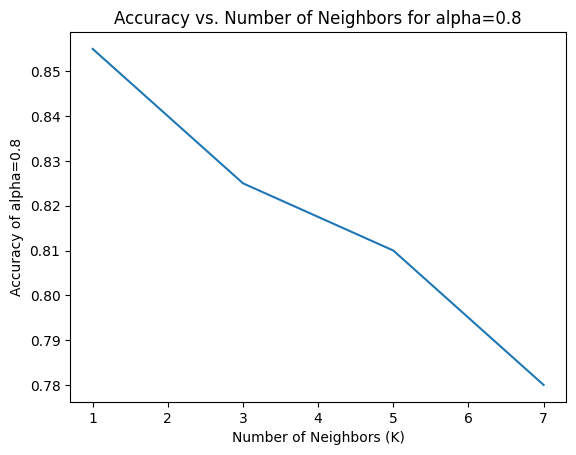

50
10304
10304
Accuracy of alpha=0.85, K=1: 0.855
Accuracy of alpha=0.85, K=3: 0.82
Accuracy of alpha=0.85, K=5: 0.82
Accuracy of alpha=0.85, K=7: 0.8


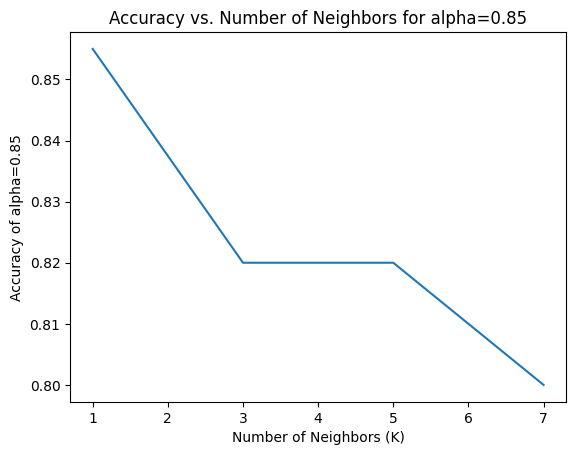

74
10304
10304
Accuracy of alpha=0.9, K=1: 0.875
Accuracy of alpha=0.9, K=3: 0.85
Accuracy of alpha=0.9, K=5: 0.815
Accuracy of alpha=0.9, K=7: 0.77


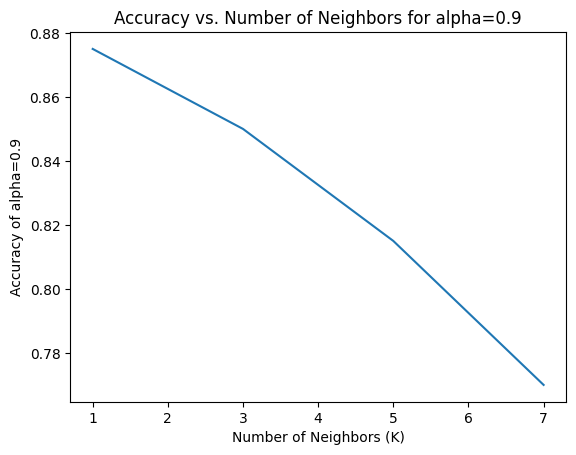

114
10304
10304
Accuracy of alpha=0.95, K=1: 0.86
Accuracy of alpha=0.95, K=3: 0.835
Accuracy of alpha=0.95, K=5: 0.815
Accuracy of alpha=0.95, K=7: 0.76


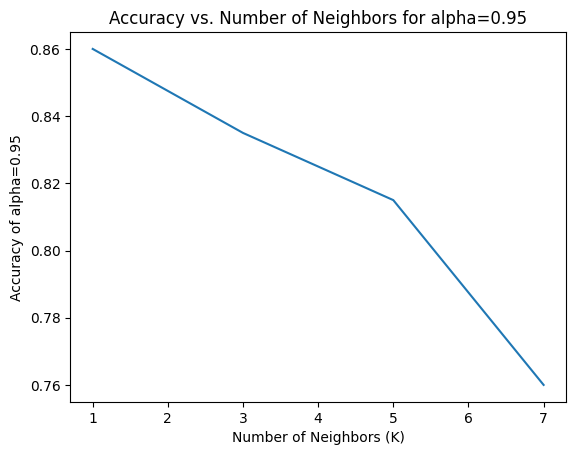

In [19]:
# alpha=[0.8,0.85,0.9,0.95]    loop on the array and mark accuracy
#consider single alpha for now
alphas = [0.8, 0.85, 0.9, 0.95]  # for example

for alpha in alphas:
  # alpha = 0.8
  # Compute the total variance
  total_variance = np.sum(sorted_eigenvalues)

  # Compute the cumulative sum of the sorted eigenvalues
  cumulative_variance = np.cumsum(sorted_eigenvalues)

  # Compute the cumulative proportion of the total variance
  cumulative_proportion = cumulative_variance / total_variance
  print(np.where(cumulative_proportion >= alpha)[0][0])

  num_eigenvectors = np.where(cumulative_proportion >= alpha)[0][0] + 1
  # final eigen vectors chosen for projection

  projected_eigenvectors = sorted_eigenvectors[:,:num_eigenvectors]
  print(len(projected_eigenvectors))
  print(len(eigenvectors))
  D_train_pca = training_centered.dot(projected_eigenvectors)
  #TODO: remember to move testing mean and centered
  testing_mean = np.mean(testing_data, axis=0)
  testing_centered = testing_data - testing_mean
  D_test_pca = testing_centered.dot(projected_eigenvectors)
  # U = sorted_eigenvectors[:, :num_eigenvectors]

  # project all the data on the eigen vectors
  # D_train_pca = np.dot(training_data, U)
  # D_test_pca = np.dot(testing_data, U)

  # training: fitting the points on the graph so the classifier can classify any new testing point
  # 5) Classifier Tuning
  knn_nums = [1, 3, 5, 7]
  accuracies = []
  for knn_num in knn_nums:
      knn = KNeighborsClassifier(n_neighbors=knn_num, weights='distance')
      knn.fit(D_train_pca, training_labels)

      # testing
      predicted_labels = knn.predict(D_test_pca)

      # accuracy
      accuracy = accuracy_score(testing_labels, predicted_labels)
      accuracies.append(accuracy)
      print(f'Accuracy of alpha={alpha}, K={knn_num}: {accuracy}')

  plt.plot(knn_nums, accuracies)
  plt.xlabel('Number of Neighbors (K)')
  plt.ylabel(f'Accuracy of alpha={alpha}')
  plt.title(f'Accuracy vs. Number of Neighbors for alpha={alpha}')
  plt.show()